# Data Preparation

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

data_dir = "data"

# Load the EMNIST dataset
train_dataset = EMNIST(
    root=data_dir,
    train=True, # loads the training dataset
    split="balanced",
    download=True,  # Downloads dataset if not already downloaded
    transform=transforms.ToTensor(),  # Converts PIL images to Torch tensors
)

test_dataset = EMNIST( # loads the test dataset
    root=data_dir,
    train=False, # load the test set
    split="balanced",
    download=True,
    transform=transforms.ToTensor(),
)

# Display dataset details
print(f"Training set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

Training set size: 112800 images
Test set size: 18800 images


# Explanations:

---
**torch** - lib. for deep learning and tensor computations

**torchvision** - package that contains utilities for image processing and datasets

**transforms** - submodule in torchvision for image transformation, e.g. to tensors

**split = "balanced"** - split letters+digits

**transform = transforms.ToTensor(**) - converts images from PIL fromat to tensors

print number of images in training and dataset

**balanced split conatins** - 47 classess of 10 digits, 26 uppercase adn 22 lowercase letters

The code dowloads the EMNIST balanced dataset, loads it into PyTorch as tensors, spearates it nto training and data sets and prints the dataset sizes.

Tensor - multi-deimensional array used in machine learning and deep learning.\
For example image tensor, change [1, 28, 28] to [28, 28] - [H,W]

# Exploring Dataset

In [2]:
classes = train_dataset.classes
print(f"Classes in the dataset:\n{classes}")

Classes in the dataset:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


Image shape: torch.Size([1, 28, 28])


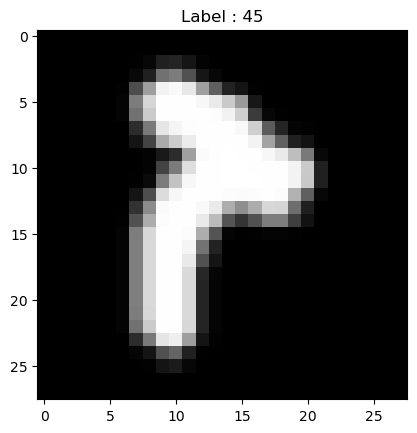

Image shape: torch.Size([1, 28, 28]) (channels, height, width)


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = train_dataset[0] # receives first image and label from training dataset
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(f"Label : {label}") # class number as title
plt.show()
print(f"Image shape: {image.shape} (channels, height, width)") # confirms original shape

# Explanations:

---
**image** - Pytorch tensor containing pixel values

**label** - numeric label corresponding to images

**.squeeze()** - removes dimensions of size 1, so [28, 28]

In [4]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
          0.0275, 0.1255, 0.1412, 0.0824, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314,
          0.1294, 0.4431, 0.4863, 0.3176, 0.0863, 0.0275, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

# Explanations:

---
Output is a PyTorch tensor representing an image from the EMNIST dataset. The values inside the tensor represent pixel intensties ina grayscale image. This pattern forms the shape of a letter or number


# Calculate Mean and Standard Deviation

In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=False)

def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squares_sum, num_batches = 0, 0, 0

    for data, _ in loader: # iterates over batches of data from train_loader
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squares_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1 # keeps track of number of batches processed

    mean = channels_sum / num_batches
    std = (channels_squares_sum/num_batches - mean**2)**0.5

    return mean, std

mean, std = get_mean_std(train_loader)

# Extract value from tensor
mean = mean.item()
std = std.item()

print(f"Mean: {mean}")
print(f"Mean: {std}")

Mean: 0.17506267130374908
Mean: 0.33320266008377075


# Explanations:

---
Normalize the images properly and standardize pixel values for better model training. Ensures stabilty by preventing large gradients during learning.

**DataLoader** - loads data in mini-batches for training

**train_loader** - wraps train_dataset inside DataLoader to efficiently iterate over batches

**channels_sum** - stores sum of pixel values

**channels_squares_sum** - stores sum of squared pixel values

**num_batches** - keeps track of number of batches processed

**Computing the mean** - torch.mean(data, dim=[0,2,3])
takes mean of all pixels across batch which is dim-0 and across hieght and width (28x28) denoted by dim=2,3
Gives single mean value per channel since greyscale, adds the channels_sum

**Mean** - average insensity of pixels across entire dataset. mean of 0.1307 means that, on average, the pixels in the dataset are slightly darker than black

**Calculating squared mean of batch** -
torch.mean(data**2, dim=[0,2,3])

**Computing final mean and standard deviation** - mean - mean = channels_sum / num_batches
Varivance calculation to get Std:

VAR[X]=E[X
^2
 ]−(E[X])
^2

STD[X]=
sqrt(VAR[X])
​

**Std** - how much pixel values vary from mean. A higher std would mean that the dataset has more contrast


# Loading Data

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transform = { # transforms images before feeding into model
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([mean,], [std,]) # centers pixel values around 0, mean removal, normalizes using mean and std values
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([mean,], [std,])
    ]),
}

# Reloading dataset

dataset = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}

dataloaders = { # wraps datasets in DataLoader to load images in mini-batches
    x: DataLoader(dataset[x], batch_size=128, shuffle=True, num_workers=2)
    for x in ['train', 'test']
}

class_names = dataset['train'].classes # contain names of classes used for interpreting labels
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'test']} # stores number of images

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Explanations:

---
**Transform** - apply normalization

# Visualize Data

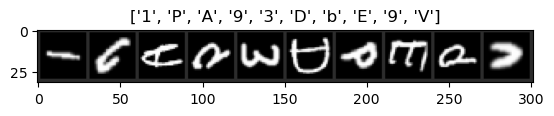

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1750,])
    std = np.array([0.3332,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)

imshow(out, title=[class_names[x] for x in classes[:10]])

# Explanations:

---
**inp.numpy()** - converts PyTorch to NumPy array

**.transpose((1, 2, 0))** - rearranges dimensons from (channels, ehight, width) to (height, width, channels)

reverse normalization through np.array()

**inp = np.clip(inp, 0, 1)** - ensures pixel values stay in valid range

**normalize** - as matplotlib does not understand negatve pixel values and won't display them correctly

# Training model

This is a general function to train a model. \
We schedule the learning rate and save the best model.

## Important keywords:

* torch.cuda.empty_cache() - Clears unused gpu memory
* cudnn.benchmark = True - Enables inbuilt cudnn auto-tuner to find best algorithm to use for your hardware
* torch.save() - Save tensors using .pt file extension
* model.state_dict() - Python dictionary object that maps each layer to its parameter tensor
* mode.train() - Sets the mode to training
* model.eval() - Sets the mode to evaluate/testing
* inputs.to(device) - Necessary to have both the model and data on the same device
* optimizer.zero_grad() - Sets gradients of all model parameters to zero. Typically, done before starting to do backpropagation
* torch.set_grad_enabled() - Will enable or disable gradients locally
* torch.max() - Returns the maximum value of all elements in the input tensor
* loss.backward() - Crucial part of backpropagation that computes the gradients of the loss with respect to all learnable parameters (weights, biases) in the model
* optimizer.step() - Perform a single optimization step to update paraneters.
* scheduler.step() - Adjust learning rate during training, based on the learning rate schedule\

## How does the code work?
1. Preparation:
   * Create temporary directory (TemporaryDirectory)to store the best model parameters
   * Save intial model parameters to best_model_params_path
2. Training loop:
   * Iterate over num_epochs and for every epoch:
     * Print epoch details
     * Iterate through two phases 'train' and 'test'
3. Training and Validation phase:
   * Training phase:
     * Set model to traning mode (model.train())
     * Iterate through the training dataset (dataloaders['train'])
     * Move inputs and labels to the appropiate device (inputs.to(device) & labels.to(device))
     * Clear opimizer gradients (optimizer.zero_grad())
     * Perform forward propagation
     * Compute loss
     * Perform backpropagation (loss.backward())
     * Update model weights (optimizer.step())
     * Track statistics (loss and accuracy)
     * Adjust learning rate (scheduler.step())
   * Validation phase:
     * Set model to evaluation mode (model.eval())
     * Do not update gradients (torch.set_grad_enabled(phase == 'train'))
     * Compute loss and accuracy on validation set
     * Save the best model if accuracy improved

   
Gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

In [8]:
import torch
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os

torch.cuda.empty_cache() # clear unused gpu memory
cudnn.benchmark = True # Enables inbuilt auto-tuner to find best algorithm for your hardware

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    # Tracking best models weights 
    # Only the best model is kept
    with TemporaryDirectory() as tempdir:
        
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        
        best_acc = 0.0

        for epoch in range(num_epochs):
            
            # Print out epochs - see later on
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing/validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Visualizing model predictions

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Explanations:

---
**visualize_model** - vsualizes model predictions on the test dataset by displaying images along with predicted values

**evaluation mode** - disables dropout, batch norm updates

**with torch.no_grad():** - turns off gradient calculations to save memory and speed up inference, gradients are only needed during training

**.to(device)** - moves to GPU if available

**torch.max(outputs, 1)** - gets class with highest probablity for each image

**preds** - contains predicted labels

**imshow()** - de-normalize image
goes back to orginal mode

# Finetuning ConvNet

In [10]:
import torch
import torchvision
from torchvision.models import resnet50

model = resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Explanations:

---
Modifies pre-trained ResNet-50 model by adjusting the input and output layers, setting up the loss function, optimizer, and learning rate scheduler. Why use a pre-trained model?
*   Faster training (pre-learned features)
*   Better performance with fewer labeled examples

ResNet-50 expects RGB images (3 channels), but EMNIST is grayscale (1 channel).

Replaces the first convolutional layer:
Conv2d(1, 64, kernel_size=3, padding=1)

1 input channel (grayscale images).

64 output channels (same as original ResNet-50).

Kernel size = 3x3 (instead of 7x7, better for small 28x28 images).

**Padding** = 1 ensures output size remains unchanged.

**SGD** - stochastic gradient descent used for optimization

**Hyperparamters:**

*lr=0.002* → Learning rate (controls step size in weight updates).

*momentum=0.9* → Helps prevent oscillations in updates.

*step_size = 7* - StepLR scheduler reduces learning rate every 7 epochs

*gamme = 0.1* - reuces LR by multiplying it by 0.1

*Scheduler* - helps fine-tune learning rate dynamically, prevents overshooting and improves convergence



# Train and evaluate

In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/home/moritz/miniconda3/envs/mnist_ml/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


train Loss: 0.6382 Acc: 0.8090
test Loss: 0.3414 Acc: 0.8766

Epoch 1/9
----------
train Loss: 0.2851 Acc: 0.8941
test Loss: 0.3249 Acc: 0.8823

Epoch 2/9
----------
train Loss: 0.2307 Acc: 0.9109
test Loss: 0.3131 Acc: 0.8893

Epoch 3/9
----------
train Loss: 0.1974 Acc: 0.9214
test Loss: 0.3221 Acc: 0.8883

Epoch 4/9
----------
train Loss: 0.1691 Acc: 0.9305
test Loss: 0.3315 Acc: 0.8876

Epoch 5/9
----------
train Loss: 0.1498 Acc: 0.9381
test Loss: 0.3545 Acc: 0.8852

Epoch 6/9
----------
train Loss: 0.1333 Acc: 0.9442
test Loss: 0.3641 Acc: 0.8883

Epoch 7/9
----------
train Loss: 0.0939 Acc: 0.9630
test Loss: 0.3554 Acc: 0.8924

Epoch 8/9
----------
train Loss: 0.0780 Acc: 0.9700
test Loss: 0.3709 Acc: 0.8921

Epoch 9/9
----------
train Loss: 0.0705 Acc: 0.9736
test Loss: 0.3780 Acc: 0.8910

Training complete in 9m 8s
Best val Acc: 0.892447


# Explanations:

---
**model** - modified ResNet-50 that was modified to work with grayscale EMNIST images - modified first convolutional layer for grayscale imput and new FC layer
criterion - loss function measure how far predicted outputs are from the true labels

**optimizer** - SGD - lr - controls step size for weight updates, momemntum - helps stabilize training

**exp_lr_scheduler** - dynamically adjust learning rate every 7 epochs, multple by 0.1 after every 7 epochs

**num_epochs** - runs 10 complete passes over dataset


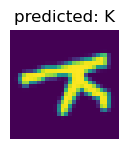

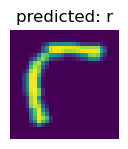

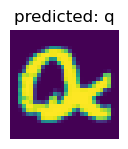

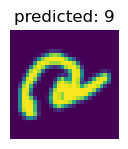

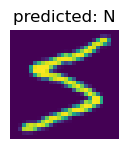

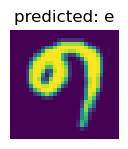

In [12]:
visualize_model(model)

# Visualize model prediction with actual values

In [17]:
def visualize_model_predictions(model, dataloader, class_names, device, num_images):

    was_training = model.training
    model.eval()
    images_shown = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_shown += 1
                ax = plt.subplot(num_images // 2, 2, images_shown)
                ax.axis('off')
                ax.set_title(f'Actual: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_shown == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Explanations:

---
**was_training = model.training** - stores model's original mode

**model.eval()** - sets model to evaluation mode, turns off drouput and batch norm updates

**model(inputs)** - feeds images into model to get predicted outputs


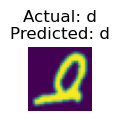

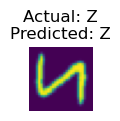

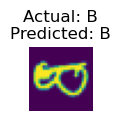

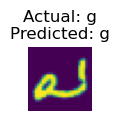

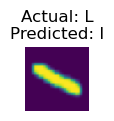

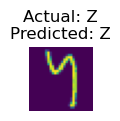

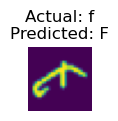

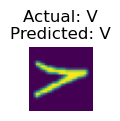

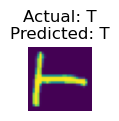

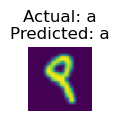

In [28]:
visualize_model_predictions(
    model=model,
    dataloader=dataloaders['test'],
    class_names=class_names,
    device=device,
    num_images=10
)

# Explanations:

---
**model = model** - make predictions on test images

**dataloaders['test']** - provides test images and their actual labels.

The function will loop through this dataloader to fetch a batch of test images.
class_names to convert numeric labels to human-readable text.
